# Quantitative Analysis using TA-Lib and PyNance

This notebook demonstrates quantitative analysis techniques using TA-Lib and PyNance for financial metrics calculations. We'll apply various technical indicators, calculate financial metrics, and visualize the results.


## 1. Setup and Data Loading

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from datetime import datetime, timedelta

# Add the project directory to path
sys.path.append('..')

# Import our custom modules
import src.data.loader
from src.features.talib_indicators import add_all_indicators, generate_trading_signals, calculate_strategy_returns, backtest_strategy
from src.features.pynance_metrics import calculate_all_pynance_metrics, calculate_pynance_statistics
from src.visualization.talib_visualization import plot_price_with_ma, plot_momentum_indicators, plot_macd, \
    plot_volatility_indicators, plot_trading_signals, plot_strategy_performance, \
    plot_pynance_metrics, plot_correlation_matrix, create_full_analysis_dashboard

# Set plotting style
sns.set_theme(style='darkgrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

### Load Stock Data

We'll load stock data for multiple companies and prepare it for analysis.

In [92]:
# Define the stock symbols and date range
symbols = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META']
market_symbol = 'SPY'  # S&P 500 ETF as market benchmark

# Set date range (3 years of data)
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=3*365)).strftime('%Y-%m-%d')

print(f"Loading stock data from {start_date} to {end_date}")

Loading stock data from 2022-05-31 to 2025-05-30


In [93]:
# Create data directory if it doesn't exist
os.makedirs('../data/processed', exist_ok=True)

# Load data for each symbol
stock_data = {}
for symbol in symbols + [market_symbol]:
    try:
        print(f"Loading data for {symbol}...")
        df = load_stock_data(symbol, start_date, end_date)
        
        # Basic validation
        if df is not None and not df.empty:
            stock_data[symbol] = df
            print(f"  Loaded {len(df)} rows of data for {symbol}")
        else:
            print(f"  Error: No data loaded for {symbol}")
    except Exception as e:
        print(f"  Error loading data for {symbol}: {e}")

# Check if we have data for at least one symbol
if not stock_data:
    raise ValueError("No stock data was loaded successfully.")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Loading data for AAPL...
  Loaded 752 rows of data for AAPL
Loading data for MSFT...
  Loaded 752 rows of data for MSFT
Loading data for AMZN...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  Loaded 752 rows of data for AMZN
Loading data for GOOGL...
  Loaded 752 rows of data for GOOGL
Loading data for META...
  Loaded 752 rows of data for META
Loading data for SPY...
  Loaded 752 rows of data for SPY


In [94]:
# Display the first few rows of the first stock
first_symbol = list(stock_data.keys())[0]
print(f"Preview of {first_symbol} data:")
stock_data[first_symbol].head()

Preview of AAPL data:


Price,Close,High,Low,Open,Volume,ticker
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,
Date,,,,,,
2022-05-31,146.489822,148.281092,144.521402,146.716202,103718400,AAPL
2022-06-01,146.361862,149.344017,145.348112,147.533059,74286600,AAPL
2022-06-02,148.822418,148.881468,144.541098,145.495783,72348100,AAPL
2022-06-03,143.084427,145.633527,142.178956,144.580415,88570300,AAPL
2022-06-06,143.832458,146.224097,142.612033,144.708405,71598400,AAPL


## 2. Technical Analysis with TA-Lib

We'll apply technical indicators from the TA library to our stock data.

In [95]:
# Add technical indicators to each stock
for symbol in stock_data.keys():
    print(f"\nAdding technical indicators for {symbol}...")
    # Use the simple indicators module instead
    from src.features.simple_indicators import add_all_simple_indicators
    stock_data[symbol] = add_all_simple_indicators(stock_data[symbol])
    
# Show the available indicators for the first stock
print(f"\nColumns in {first_symbol} after adding technical indicators:")
# Get the column names regardless of whether they're in a tuple or index
if hasattr(stock_data[first_symbol].columns, 'levels'):  # Multi-index columns
    # Flatten the multi-index columns
    all_cols = []
    for col in stock_data[first_symbol].columns.to_flat_index():
        if isinstance(col, tuple):
            all_cols.extend(col)
        else:
            all_cols.append(col)
    # Filter to find indicator columns
    basic_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'ticker']
    indicator_cols = [col for col in all_cols if col not in basic_cols and isinstance(col, str)]
else:  # Single-level index
    basic_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'ticker']
    indicator_cols = [col for col in stock_data[first_symbol].columns if col not in basic_cols]

print(f"Number of technical indicators: {len(indicator_cols)}")
if indicator_cols:
    print(f"Indicators: {', '.join(str(col) for col in indicator_cols[:10])}...")
else:
    print("No indicators found. Using simple indicators instead...")
    # Try using simple_indicators module instead
    from src.features.simple_indicators import add_all_simple_indicators
    stock_data[first_symbol] = add_all_simple_indicators(stock_data[first_symbol])
    # Check again
    all_cols = stock_data[first_symbol].columns.tolist()
    basic_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'ticker'] 
    indicator_cols = [col for col in all_cols if col not in basic_cols]
    print(f"Found {len(indicator_cols)} indicators after using simple_indicators")
    if indicator_cols:
        print(f"Indicators: {', '.join(str(col) for col in indicator_cols[:10])}...")


Adding technical indicators for AAPL...
Adding simple technical indicators...
  Adding moving averages...
  Adding RSI...
  Adding Bollinger Bands...
Error adding simple indicators: Cannot set a DataFrame with multiple columns to the single column bb_upper

Adding technical indicators for MSFT...
Adding simple technical indicators...
  Adding moving averages...
  Adding RSI...
  Adding Bollinger Bands...
Error adding simple indicators: Cannot set a DataFrame with multiple columns to the single column bb_upper

Adding technical indicators for AMZN...
Adding simple technical indicators...
  Adding moving averages...
  Adding RSI...
  Adding Bollinger Bands...
Error adding simple indicators: Cannot set a DataFrame with multiple columns to the single column bb_upper

Adding technical indicators for GOOGL...
Adding simple technical indicators...
  Adding moving averages...
  Adding RSI...
  Adding Bollinger Bands...
Error adding simple indicators: Cannot set a DataFrame with multiple colum

### Visualize Key Technical Indicators

Let's visualize some of the key technical indicators we've calculated.

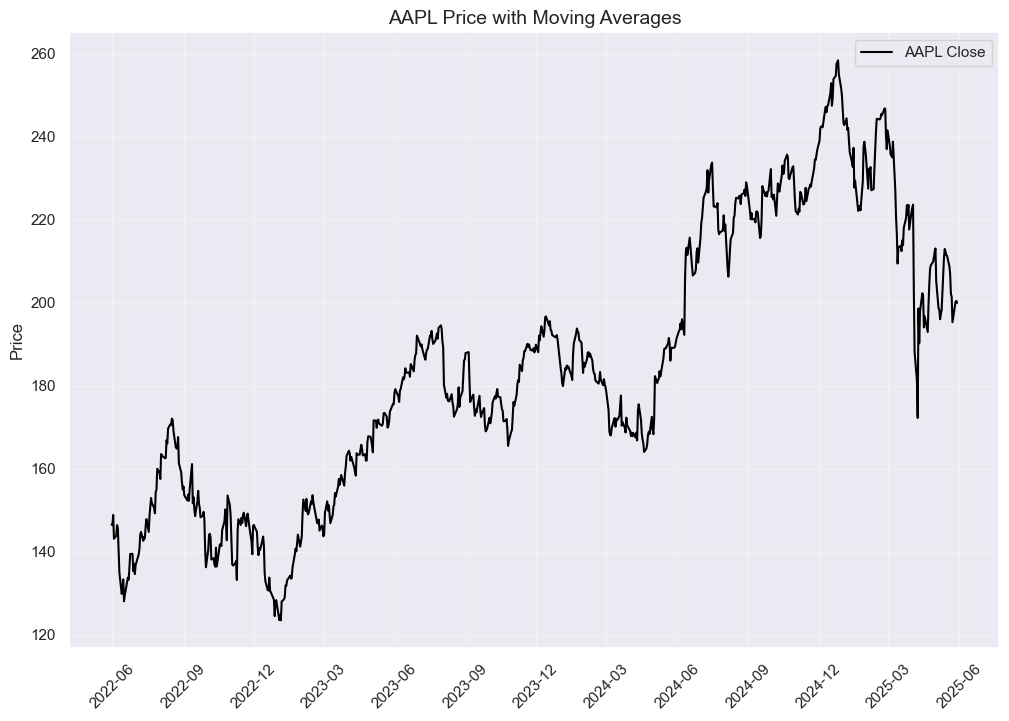

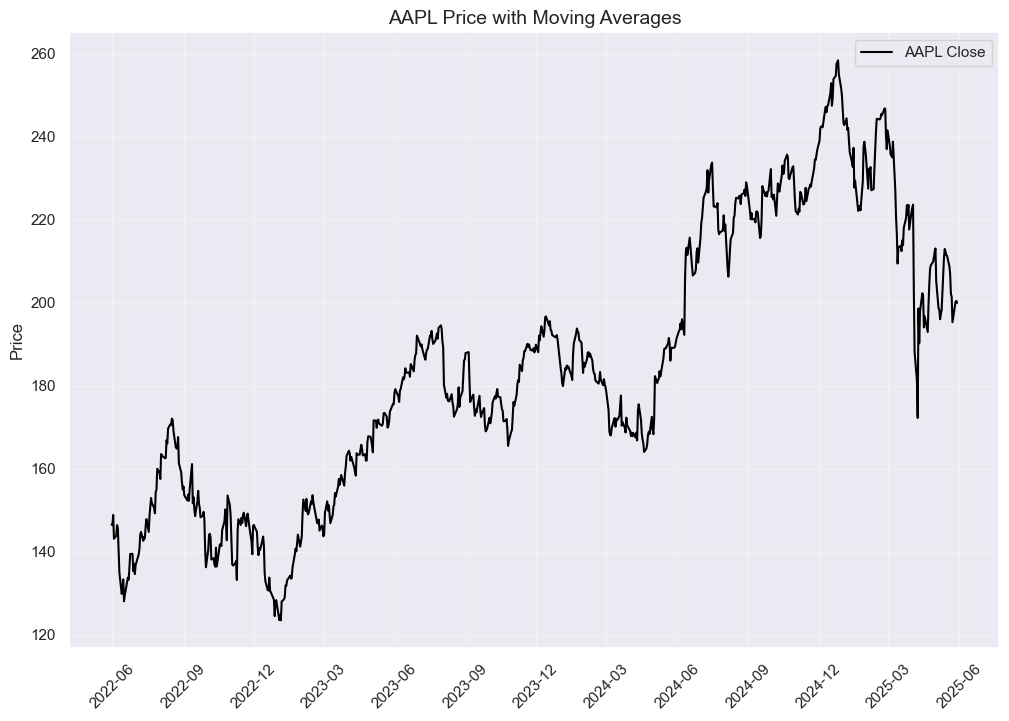

In [96]:
# Select a stock for visualization
viz_symbol = 'AAPL'
viz_df = stock_data[viz_symbol]

# Plot price with moving averages
plot_price_with_ma(viz_df, viz_symbol)